In [61]:

from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ammarqurthuby","key":"2a3b76068aedf2c65d90da00261ee426"}'}

In [62]:
import os
# Membuat folder .kaggle jika belum ada
os.makedirs('/root/.kaggle', exist_ok=True)

# Pindahkan file kaggle.json ke folder .kaggle
!mv kaggle.json /root/.kaggle/

# Ubah permission file agar bisa dibaca
!chmod 600 /root/.kaggle/kaggle.json


In [63]:
!kaggle competitions download -c uas-pembelajaran-mesin-genap-2024-2025

uas-pembelajaran-mesin-genap-2024-2025.zip: Skipping, found more recently modified local copy (use --force to force download)


In [64]:
import zipfile

# Ekstrak semua file dalam ZIP
with zipfile.ZipFile('uas-pembelajaran-mesin-genap-2024-2025.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [82]:
!python3 /content/cifar_competition/image_classification_32x32.py

2025-05-25 00:32:02.116470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748133122.137416   15893 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748133122.143669   15893 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten, Dropout,
    BatchNormalization, GlobalAveragePooling2D, Add, Input,
    Activation, Concatenate
)
from tensorflow.keras.optimizers import AdamW, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Configure GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU memory growth enabled")


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth enabled


In [66]:
    # Load datasets
    train_df = pd.read_csv('/content/cifar_competition/train.csv')
    test_df = pd.read_csv('/content/cifar_competition/test.csv')

    print(f"Training samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
    print(f"Training columns: {train_df.columns.tolist()}")
    print(f"Test columns: {test_df.columns.tolist()}")

Training samples: 50000
Test samples: 10000
Training columns: ['id', 'label']
Test columns: ['id']



=== CLASS DISTRIBUTION ANALYSIS ===


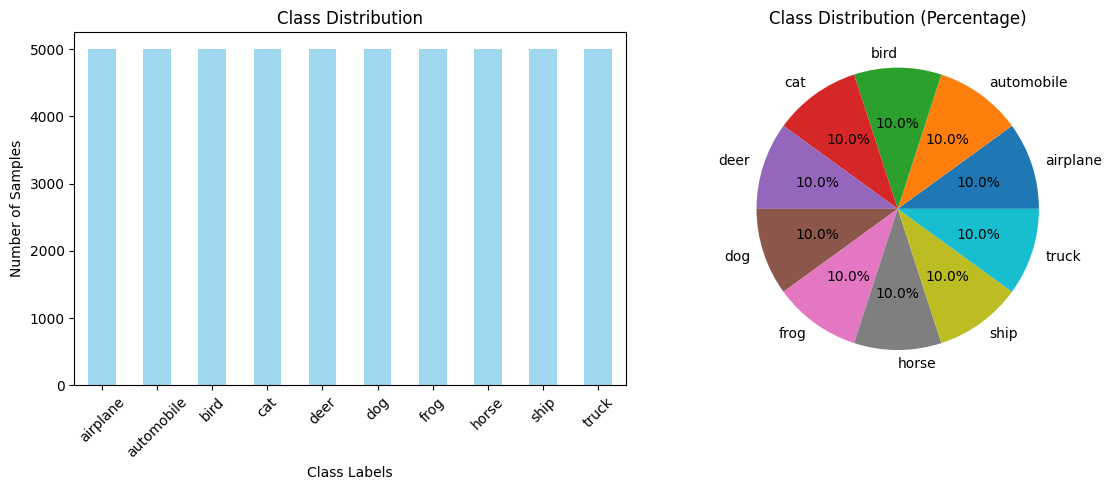

Total classes: 10
Most frequent class: 5000 samples
Least frequent class: 5000 samples
Imbalance ratio: 1.00
Class 'airplane': 5000 samples (10.0%)
Class 'automobile': 5000 samples (10.0%)
Class 'bird': 5000 samples (10.0%)
Class 'cat': 5000 samples (10.0%)
Class 'deer': 5000 samples (10.0%)
Class 'dog': 5000 samples (10.0%)
Class 'frog': 5000 samples (10.0%)
Class 'horse': 5000 samples (10.0%)
Class 'ship': 5000 samples (10.0%)
Class 'truck': 5000 samples (10.0%)


In [67]:
# Analyze class distribution
print("\n=== CLASS DISTRIBUTION ANALYSIS ===")
class_counts = train_df['label'].value_counts().sort_index()

plt.figure(figsize=(12, 5))

# Bar plot
plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Total classes: {len(class_counts)}")
print(f"Most frequent class: {class_counts.max()} samples")
print(f"Least frequent class: {class_counts.min()} samples")
print(f"Imbalance ratio: {class_counts.max() / class_counts.min():.2f}")

for label, count in class_counts.items():
    print(f"Class '{label}': {count} samples ({count/len(train_df)*100:.1f}%)")


In [68]:
# Check for missing images and data quality
print("\n=== DATA QUALITY CHECK ===")

missing_train_images = []
missing_test_images = []

# Check training images
for idx, row in train_df.iterrows():
    img_path = os.path.join('/content/cifar_competition/train_images', row['id'])
    if not os.path.exists(img_path):
        missing_train_images.append(row['id'])

# Check test images
for idx, row in test_df.iterrows():
    img_path = os.path.join('/content/cifar_competition/test_images', row['id'])
    if not os.path.exists(img_path):
        missing_test_images.append(row['id'])

print(f"Missing training images: {len(missing_train_images)}")
print(f"Missing test images: {len(missing_test_images)}")

if missing_train_images:
    print("Removing rows with missing training images...")
    train_df = train_df[~train_df['id'].isin(missing_train_images)]
    print(f"Updated training samples: {len(train_df)}")

# Get final class information
unique_labels = sorted(train_df['label'].unique())
num_classes = len(unique_labels)
print(f"Final number of classes: {num_classes}")
print(f"Class labels: {unique_labels}")



=== DATA QUALITY CHECK ===
Missing training images: 0
Missing test images: 0
Final number of classes: 10
Class labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


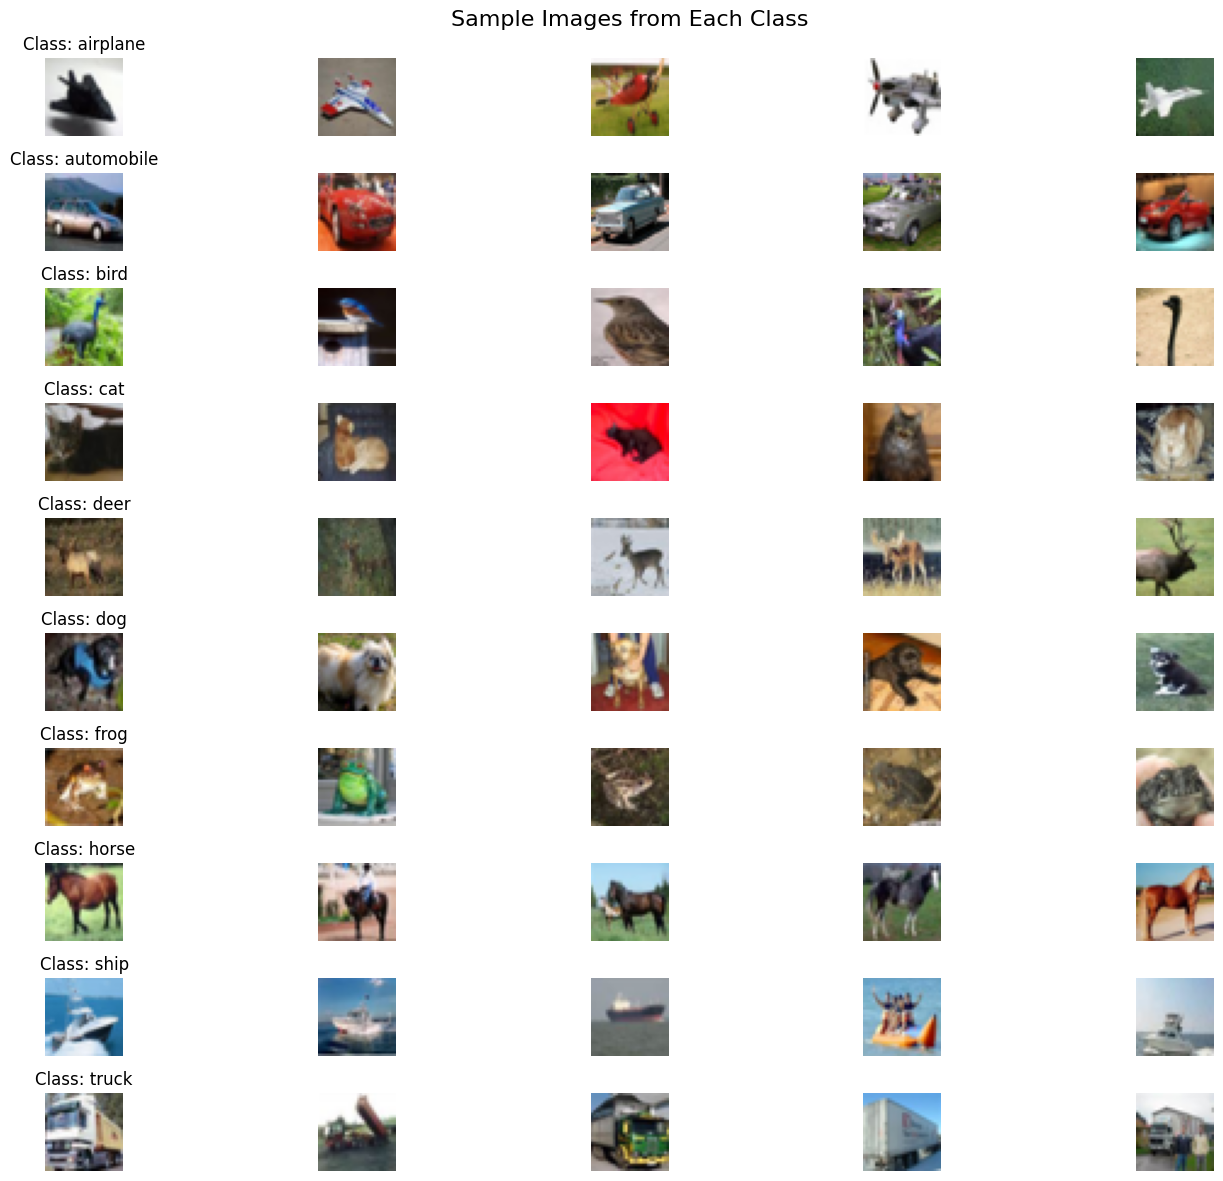

In [69]:
def plot_sample_images(df, img_dir, n_samples=5, figsize=(15, 12)):
    """Plot sample images from each class"""
    unique_labels = sorted(df['label'].unique())
    n_classes = len(unique_labels)

    fig, axes = plt.subplots(n_classes, n_samples, figsize=figsize)
    if n_classes == 1:
        axes = axes.reshape(1, -1)

    for i, label in enumerate(unique_labels):
        class_data = df[df['label'] == label]
        sample_ids = class_data['id'].head(n_samples).values

        for j, img_id in enumerate(sample_ids):
            img_path = os.path.join(img_dir, img_id)

            if os.path.exists(img_path):
                img = plt.imread(img_path)
                axes[i, j].imshow(img)
                axes[i, j].set_title(f'Class: {label}' if j == 0 else '')
                axes[i, j].axis('off')
            else:
                axes[i, j].text(0.5, 0.5, 'Image\nNot Found',
                               ha='center', va='center', transform=axes[i, j].transAxes)
                axes[i, j].axis('off')

    plt.suptitle('Sample Images from Each Class', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Plot sample images
plot_sample_images(train_df, '/content/cifar_competition/train_images', n_samples=5)



=== CLASS DISTRIBUTION ===


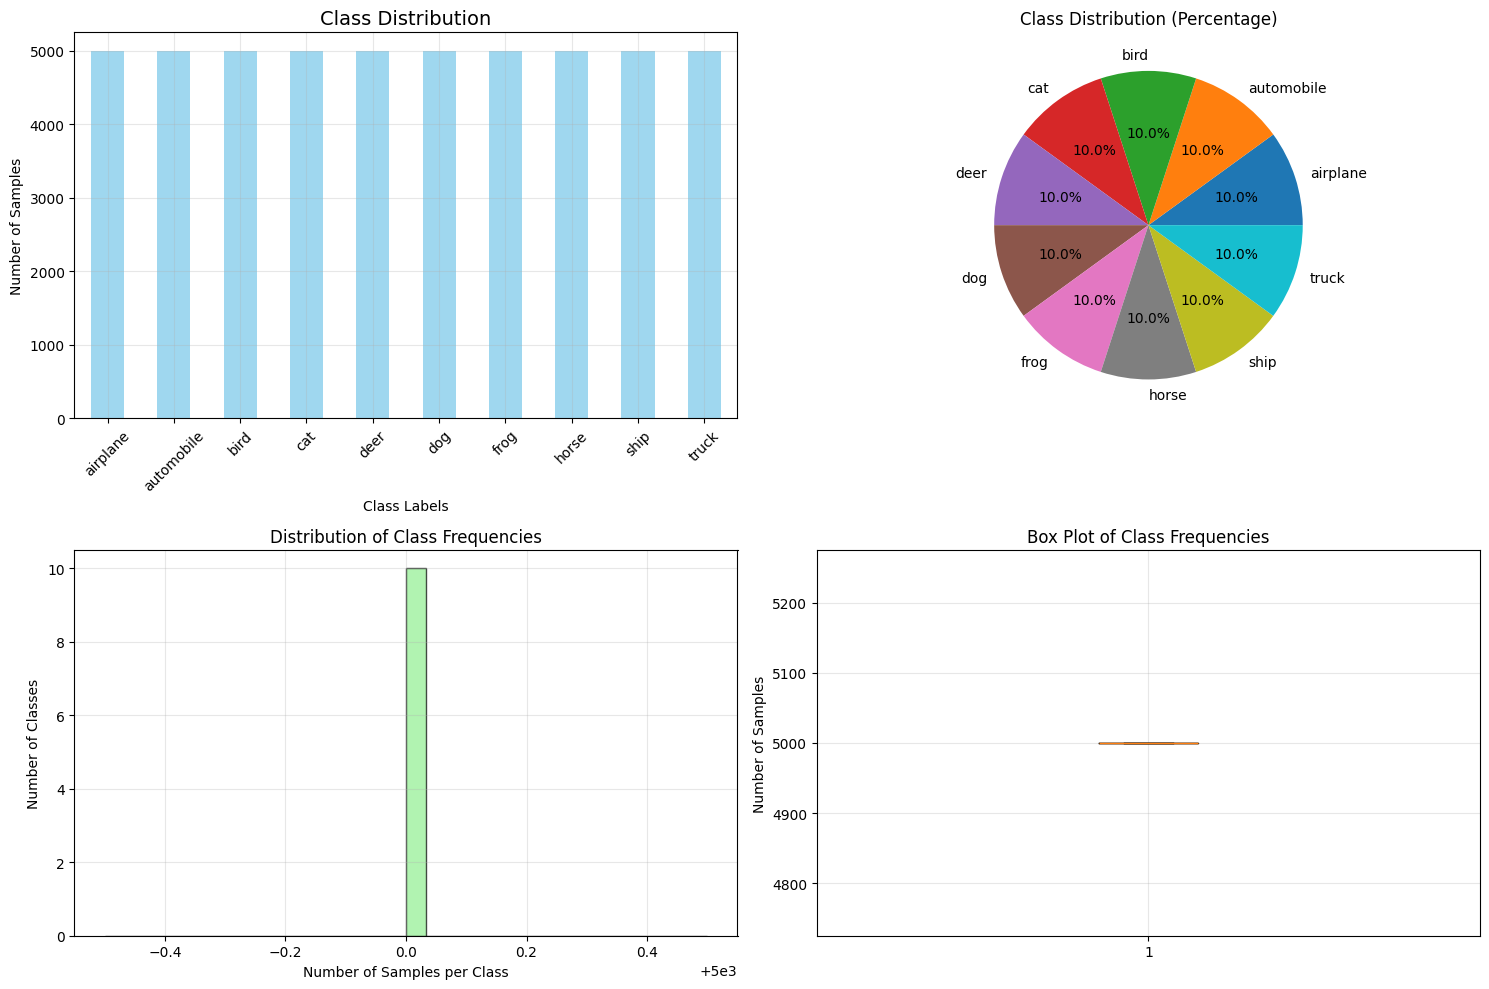

Total classes: 10
Most frequent class: 5000 samples
Least frequent class: 5000 samples
Mean samples per class: 5000.00
Median samples per class: 5000.00
Standard deviation: 0.00
Imbalance ratio: 1.00


In [71]:
# 3. Analyze Class Distribution
def analyze_class_distribution(train_df):
    """Analyze and visualize class distribution"""
    print("\n=== CLASS DISTRIBUTION ===")
    class_counts = train_df['label'].value_counts().sort_index()

    plt.figure(figsize=(15, 10))

    # Bar plot
    plt.subplot(2, 2, 1)
    class_counts.plot(kind='bar', color='skyblue', alpha=0.8)
    plt.title('Class Distribution', fontsize=14)
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Pie chart (top 10 classes if too many)
    plt.subplot(2, 2, 2)
    if len(class_counts) > 10:
        top_classes = class_counts.head(10)
        others_count = class_counts.tail(len(class_counts) - 10).sum()
        if others_count > 0:
            plot_data = pd.concat([top_classes, pd.Series([others_count], index=['Others'])])
        else:
            plot_data = top_classes
    else:
        plot_data = class_counts

    plt.pie(plot_data.values, labels=plot_data.index, autopct='%1.1f%%')
    plt.title('Class Distribution (Percentage)')

    # Histogram of class frequencies
    plt.subplot(2, 2, 3)
    plt.hist(class_counts.values, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.title('Distribution of Class Frequencies')
    plt.xlabel('Number of Samples per Class')
    plt.ylabel('Number of Classes')
    plt.grid(True, alpha=0.3)

    # Box plot of class frequencies
    plt.subplot(2, 2, 4)
    plt.boxplot(class_counts.values, vert=True)
    plt.title('Box Plot of Class Frequencies')
    plt.ylabel('Number of Samples')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Total classes: {len(class_counts)}")
    print(f"Most frequent class: {class_counts.max()} samples")
    print(f"Least frequent class: {class_counts.min()} samples")
    print(f"Mean samples per class: {class_counts.mean():.2f}")
    print(f"Median samples per class: {class_counts.median():.2f}")
    print(f"Standard deviation: {class_counts.std():.2f}")
    print(f"Imbalance ratio: {class_counts.max() / class_counts.min():.2f}")

    return class_counts

# Call the function to analyze class distribution
class_counts = analyze_class_distribution(train_df)


In [70]:
# Configuration
IMG_SIZE = 32  # Keep original size for 32x32 images
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2

print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Validation split: {VALIDATION_SPLIT}")


Image size: 32x32
Batch size: 64
Validation split: 0.2


In [88]:
def create_train_augmentation():
    """Create data augmentation for training - optimized for 32x32 images"""
    return ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,          # Conservative rotation for small images
        width_shift_range=0.1,      # Small shifts to preserve information
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.9, 1.1], # Subtle brightness changes
        fill_mode='nearest',
        validation_split=VALIDATION_SPLIT
    )

def create_validation_augmentation():
    """Create minimal augmentation for validation"""
    return ImageDataGenerator(
        rescale=1./255,
        validation_split=VALIDATION_SPLIT
    )

def create_test_augmentation():
    """Create augmentation for test data"""
    return ImageDataGenerator(rescale=1./255)

print("Data augmentation generators created successfully!")


Data augmentation generators created successfully!


In [89]:
# Create data generators
train_datagen = create_train_augmentation()
val_datagen = create_validation_augmentation()
test_datagen = create_test_augmentation()

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/cifar_competition/train_images',
    x_col='id',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Validation generator
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/cifar_competition/train_images',
    x_col='id',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/content/cifar_competition/test_images',
    x_col='id',
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")
print(f"Class indices: {train_generator.class_indices}")


Found 40000 validated image filenames belonging to 10 classes.
Found 10000 validated image filenames belonging to 10 classes.
Found 10000 validated image filenames.
Training samples: 40000
Validation samples: 10000
Test samples: 10000


AttributeError: 'DataFrameIterator' object has no attribute 'num_classes'

In [90]:
# Calculate class weights for imbalanced datasets
def calculate_class_weights(train_generator):
    """Calculate class weights to handle imbalanced datasets"""
    class_counts = {}

    # Get class distribution from generator
    for class_name, class_index in train_generator.class_indices.items():
        class_counts[class_index] = 0

    # Count samples per class
    for i in range(len(train_generator)):
        batch_x, batch_y = train_generator[i]
        for sample_y in batch_y:
            class_index = np.argmax(sample_y)
            class_counts[class_index] += 1
        if i >= 10:  # Sample enough batches
            break

    train_generator.reset()  # Reset generator

    # Calculate weights
    total_samples = sum(class_counts.values())
    class_weights = {}

    for class_index, count in class_counts.items():
        class_weights[class_index] = total_samples / (len(class_counts) * count)

    return class_weights

# Calculate class weights
class_weights = calculate_class_weights(train_generator)
print("Class weights calculated:")
for class_idx, weight in class_weights.items():
    print(f"Class {class_idx}: {weight:.3f}")


Class weights calculated:
Class 0: 0.880
Class 1: 0.848
Class 2: 0.992
Class 3: 0.992
Class 4: 1.051
Class 5: 0.903
Class 6: 1.067
Class 7: 0.964
Class 8: 1.380
Class 9: 1.100


In [91]:
def create_optimized_cnn(num_classes, input_shape=(32, 32, 3)):
    """
    Create CNN optimized for 32x32 images
    Uses moderate depth with strong regularization
    """
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same',
               input_shape=input_shape, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.25),

        # Global Average Pooling (better than Flatten for small images)
        GlobalAveragePooling2D(),

        # Dense Layers with Regularization
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        # Output Layer
        Dense(num_classes, activation='softmax', name='predictions')
    ])

    return model

# Create the model
model = create_optimized_cnn(num_classes)

print("=== MODEL ARCHITECTURE ===")
model.summary()

# Calculate total parameters
total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")


=== MODEL ARCHITECTURE ===


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 512)            │             

 Total params: 852,650 (3.25 MB)

 Trainable params: 850,154 (3.24 MB)

 Non-trainable params: 2,496 (9.75 KB)


Total parameters: 852,650


In [92]:
def create_resnet_small(num_classes, input_shape=(32, 32, 3)):
    """
    Create a small ResNet-style model for 32x32 images
    Alternative architecture with residual connections
    """
    def residual_block(x, filters, kernel_size=3, stride=1, name_prefix=""):
        shortcut = x

        # First convolution
        x = Conv2D(filters, kernel_size, strides=stride, padding='same',
                   kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv1')(x)
        x = BatchNormalization(name=f'{name_prefix}_bn1')(x)
        x = tf.keras.activations.relu(x)

        # Second convolution
        x = Conv2D(filters, kernel_size, padding='same',
                   kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv2')(x)
        x = BatchNormalization(name=f'{name_prefix}_bn2')(x)

        # Shortcut connection
        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = Conv2D(filters, 1, strides=stride, padding='same',
                             kernel_regularizer=l2(0.001),
                             name=f'{name_prefix}_shortcut')(shortcut)
            shortcut = BatchNormalization(name=f'{name_prefix}_shortcut_bn')(shortcut)

        # Add shortcut and apply activation
        x = Add(name=f'{name_prefix}_add')([x, shortcut])
        x = tf.keras.activations.relu(x)
        return x

    # Input
    inputs = Input(shape=input_shape)

    # Initial convolution
    x = Conv2D(32, 3, padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    # Residual blocks
    x = residual_block(x, 32, name_prefix="block1_1")
    x = residual_block(x, 32, name_prefix="block1_2")
    x = Dropout(0.2)(x)

    x = residual_block(x, 64, stride=2, name_prefix="block2_1")
    x = residual_block(x, 64, name_prefix="block2_2")
    x = Dropout(0.3)(x)

    x = residual_block(x, 128, stride=2, name_prefix="block3_1")
    x = residual_block(x, 128, name_prefix="block3_2")
    x = Dropout(0.4)(x)

    # Global pooling and output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs, name='ResNet_Small')

# Alternative model (uncomment to use)
# model = create_resnet_small(num_classes)
# print("=== RESNET SMALL ARCHITECTURE ===")
# model.summary()


In [94]:
# Compile the model
from tensorflow.keras.optimizers import Adam

optimizer = Adam(
    learning_rate=0.001,
    weight_decay=0.0001  # L2 regularization in optimizer
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

print("Model compiled successfully!")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Learning rate: {optimizer.learning_rate.numpy()}")
print(f"Weight decay: {optimizer.weight_decay}")  # Directly print the weight_decay value


Model compiled successfully!
Optimizer: Adam
Learning rate: 0.0010000000474974513
Weight decay: 0.0001


In [95]:
# Setup callbacks for training
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=7,
        min_lr=1e-8,
        verbose=1,
        cooldown=3
    ),

    # Save best model
    ModelCheckpoint(
        'best_model_32x32.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
        mode='max'
    )
]

print("Callbacks configured:")
for callback in callbacks:
    print(f"- {callback.__class__.__name__}")


Callbacks configured:
- EarlyStopping
- ReduceLROnPlateau
- ModelCheckpoint


In [96]:
# Training configuration
EPOCHS = 100  # Early stopping will control actual number
VERBOSE = 1

print("=== STARTING TRAINING ===")
print(f"Max epochs: {EPOCHS}")
print(f"Early stopping patience: 15")
print(f"Using class weights: {len(class_weights) > 0}")

# Start training
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights if class_weights else None,
    verbose=VERBOSE
)

print("=== TRAINING COMPLETED ===")


=== STARTING TRAINING ===
Max epochs: 100
Early stopping patience: 15
Using class weights: True
Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2529 - loss: 3.6332 - top_k_categorical_accuracy: 0.7658
Epoch 1: val_accuracy improved from -inf to 0.46720, saving model to best_model_32x32.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 107ms/step - accuracy: 0.2530 - loss: 3.6324 - top_k_categorical_accuracy: 0.7660 - val_accuracy: 0.4672 - val_loss: 2.4147 - val_top_k_categorical_accuracy: 0.9283 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4617 - loss: 2.4167 - top_k_categorical_accuracy: 0.9179
Epoch 2: val_accuracy improved from 0.46720 to 0.52100, saving model to best_model_32x32.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.4618 - loss: 2.4165 - top_k_categorical_accuracy: 0.9179 - val_accuracy: 0.5210 - val_loss: 2.0106 - val_top_k_categorical_accuracy: 0.9296 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5438 - loss: 1.9205 - top_k_categorical_accuracy: 0.9405
Epoch 3: val_accuracy improved from 0.52100 to 0.58040, saving model to best_model_32x32.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.5438 - loss: 1.9203 - top_k_categorical_accuracy: 0.9405 - val_accuracy: 0.5804 - val_loss: 1.7114 - val_top_k_categorical_accuracy: 0.9494 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5951 - loss: 1.6214 - top_k_categorical_accuracy: 0.9535
Epoch 4: val_accuracy improved from 0.58040 to 0.62280, saving model to best_model_32x32.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.5951 - loss: 1.6213 - top_k_categorical_accuracy: 0.9535 - val_accuracy: 0.6228 - val_loss: 1.4746 - val_top_k_categorical_accuracy: 0.9661 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6280 - loss: 1.4719 - top_k_categorical_accuracy: 0.9612
Epoch 5: val_accuracy did not improve from 0.62280
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.6280 - loss: 1.4719 - top_k_categorical_accuracy: 0.9612 - val_accuracy: 0.6165 - val_loss: 1.5370 - val_top_k_categorical_accuracy: 0.9569 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6511 - loss: 1.3876 - top_k_categorical_accuracy: 0.9649
Epoch 6: val_accuracy improved from 0.62280 to 0.68510, saving model to best_model_32x32.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.6511 - loss: 1.3876 - top_k_categorical_accuracy: 0.9649 - val_accuracy: 0.6851 - val_loss: 1.2933 - val_top_k_categorical_accuracy: 0.9714 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6753 - loss: 1.3459 - top_k_categorical_accuracy: 0.9681
Epoch 7: val_accuracy did not improve from 0.68510
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.6753 - loss: 1.3459 - top_k_categorical_accuracy: 0.9681 - val_accuracy: 0.5592 - val_loss: 1.8047 - val_top_k_categorical_accuracy: 0.9474 - learning_rate: 0.0010
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6848 - loss: 1.3212 - top_k_categorical_accuracy: 0.9694
Epoch 8: val_accuracy improved from 0.68510 to 0.68840, saving model to best_model_32x32.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.6848 - loss: 1.3212 - top_k_categorical_accuracy: 0.9694 - val_accuracy: 0.6884 - val_loss: 1.3023 - val_top_k_categorical_accuracy: 0.9746 - learning_rate: 0.0010
Epoch 9/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6968 - loss: 1.2963 - top_k_categorical_accuracy: 0.9707
Epoch 9: val_accuracy improved from 0.68840 to 0.73280, saving model to best_model_32x32.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - accuracy: 0.6968 - loss: 1.2963 - top_k_categorical_accuracy: 0.9707 - val_accuracy: 0.7328 - val_loss: 1.2036 - val_top_k_categorical_accuracy: 0.9729 - learning_rate: 0.0010
Epoch 10/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7047 - loss: 1.2812 - top_k_categorical_accuracy: 0.9733
Epoch 10: val_accuracy improved from 0.73280 to 0.73920, saving model to best_model_32x32.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.7047 - loss: 1.2812 - top_k_categorical_accuracy: 0.9733 - val_accuracy: 0.7392 - val_loss: 1.1691 - val_top_k_categorical_accuracy: 0.9800 - learning_rate: 0.0010
Epoch 11/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7077 - loss: 1.2692 - top_k_categorical_accuracy: 0.9741
Epoch 11: val_accuracy did not improve from 0.73920
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 79ms/step - accuracy: 0.7077 - loss: 1.2692 - top_k_categorical_accuracy: 0.9741 - val_accuracy: 0.6245 - val_loss: 1.6081 - val_top_k_categorical_accuracy: 0.9737 - learning_rate: 0.0010
Epoch 12/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7107 - loss: 1.2690 - top_k_categorical_accuracy: 0.9740
Epoch 12: val_accuracy did not improve from 0.73920
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.7107 - loss: 1.2690 - top_k_categorical_accuracy: 0.9740 - val_accuracy: 0.7376 - val_loss: 1.1919 - val_top_k_categorical_accuracy: 0.9750 - lea

625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.7637 - loss: 1.0865 - top_k_categorical_accuracy: 0.9832 - val_accuracy: 0.8170 - val_loss: 0.8752 - val_top_k_categorical_accuracy: 0.9915 - learning_rate: 3.0000e-04
Epoch 19/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7888 - loss: 0.9687 - top_k_categorical_accuracy: 0.9861
Epoch 19: val_accuracy did not improve from 0.81700
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.7888 - loss: 0.9687 - top_k_categorical_accuracy: 0.9861 - val_accuracy: 0.8160 - val_loss: 0.8538 - val_top_k_categorical_accuracy: 0.9914 - learning_rate: 3.0000e-04
Epoch 20/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7923 - loss: 0.9250 - top_k_categorical_accuracy: 0.9855
Epoch 20: val_accuracy did not improve from 0.81700
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.7923 - loss: 0.9250 - top_k_categorical_accuracy: 0.9855 - val_accuracy: 0.8020 - val_loss: 0.8930 - val_top_k_categorical_accuracy: 0.98

625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - accuracy: 0.7941 - loss: 0.8733 - top_k_categorical_accuracy: 0.9859 - val_accuracy: 0.8350 - val_loss: 0.7663 - val_top_k_categorical_accuracy: 0.9901 - learning_rate: 3.0000e-04
Epoch 23/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8026 - loss: 0.8497 - top_k_categorical_accuracy: 0.9863
Epoch 23: val_accuracy did not improve from 0.83500
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.8026 - loss: 0.8497 - top_k_categorical_accuracy: 0.9863 - val_accuracy: 0.8006 - val_loss: 0.8654 - val_top_k_categorical_accuracy: 0.9878 - learning_rate: 3.0000e-04
Epoch 24/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8034 - loss: 0.8349 - top_k_categorical_accuracy: 0.9876
Epoch 24: val_accuracy did not improve from 0.83500
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.8034 - loss: 0.8349 - top_k_categorical_accuracy: 0.9876 - val_accuracy: 0.8214 - val_loss: 0.7757 - val_top_k_categorical_accuracy: 0.99

625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.8105 - loss: 0.7784 - top_k_categorical_accuracy: 0.9904 - val_accuracy: 0.8452 - val_loss: 0.6923 - val_top_k_categorical_accuracy: 0.9911 - learning_rate: 3.0000e-04
Epoch 31/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8195 - loss: 0.7643 - top_k_categorical_accuracy: 0.9899
Epoch 31: val_accuracy did not improve from 0.84520
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.8195 - loss: 0.7644 - top_k_categorical_accuracy: 0.9899 - val_accuracy: 0.8358 - val_loss: 0.7198 - val_top_k_categorical_accuracy: 0.9921 - learning_rate: 3.0000e-04
Epoch 32/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8161 - loss: 0.7791 - top_k_categorical_accuracy: 0.9889
Epoch 32: val_accuracy did not improve from 0.84520
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.8161 - loss: 0.7791 - top_k_categorical_accuracy: 0.9889 - val_accuracy: 0.8265 - val_loss: 0.7426 - val_top_k_categorical_accuracy: 0.99

625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 78ms/step - accuracy: 0.8211 - loss: 0.7521 - top_k_categorical_accuracy: 0.9910 - val_accuracy: 0.8500 - val_loss: 0.6919 - val_top_k_categorical_accuracy: 0.9903 - learning_rate: 3.0000e-04
Epoch 37/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8161 - loss: 0.7622 - top_k_categorical_accuracy: 0.9903
Epoch 37: val_accuracy did not improve from 0.85000
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 79ms/step - accuracy: 0.8161 - loss: 0.7622 - top_k_categorical_accuracy: 0.9903 - val_accuracy: 0.8407 - val_loss: 0.7048 - val_top_k_categorical_accuracy: 0.9908 - learning_rate: 3.0000e-04
Epoch 38/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8200 - loss: 0.7523 - top_k_categorical_accuracy: 0.9895
Epoch 38: val_accuracy did not improve from 0.85000
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.8200 - loss: 0.7523 - top_k_categorical_accuracy: 0.9895 - val_accuracy: 0.8408 - val_loss: 0.6931 - val_top_k_categorical_accuracy: 0.99

625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.8411 - loss: 0.6860 - top_k_categorical_accuracy: 0.9927 - val_accuracy: 0.8517 - val_loss: 0.6667 - val_top_k_categorical_accuracy: 0.9937 - learning_rate: 9.0000e-05
Epoch 51/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8544 - loss: 0.6474 - top_k_categorical_accuracy: 0.9931
Epoch 51: val_accuracy improved from 0.85170 to 0.87110, saving model to best_model_32x32.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.8544 - loss: 0.6474 - top_k_categorical_accuracy: 0.9931 - val_accuracy: 0.8711 - val_loss: 0.6019 - val_top_k_categorical_accuracy: 0.9953 - learning_rate: 9.0000e-05
Epoch 52/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8535 - loss: 0.6413 - top_k_categorical_accuracy: 0.9929
Epoch 52: val_accuracy improved from 0.87110 to 0.87400, saving model to best_model_32x32.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.8535 - loss: 0.6413 - top_k_categorical_accuracy: 0.9929 - val_accuracy: 0.8740 - val_loss: 0.5878 - val_top_k_categorical_accuracy: 0.9956 - learning_rate: 9.0000e-05
Epoch 53/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8524 - loss: 0.6315 - top_k_categorical_accuracy: 0.9942
Epoch 53: val_accuracy improved from 0.87400 to 0.87410, saving model to best_model_32x32.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.8524 - loss: 0.6315 - top_k_categorical_accuracy: 0.9942 - val_accuracy: 0.8741 - val_loss: 0.5824 - val_top_k_categorical_accuracy: 0.9951 - learning_rate: 9.0000e-05
Epoch 54/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8560 - loss: 0.6204 - top_k_categorical_accuracy: 0.9929
Epoch 54: val_accuracy did not improve from 0.87410
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 79ms/step - accuracy: 0.8560 - loss: 0.6204 - top_k_categorical_accuracy: 0.9929 - val_accuracy: 0.8721 - val_loss: 0.5805 - val_top_k_categorical_accuracy: 0.9943 - learning_rate: 9.0000e-05
Epoch 55/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8559 - loss: 0.6154 - top_k_categorical_accuracy: 0.9928
Epoch 55: val_accuracy did not improve from 0.87410
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.8559 - loss: 0.6153 - top_k_categorical_accuracy: 0.9928 - val_accuracy: 0.8645 - val_loss: 0.6060 - val_top_k_categorical_accuracy: 0.99

625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - accuracy: 0.8611 - loss: 0.6037 - top_k_categorical_accuracy: 0.9938 - val_accuracy: 0.8765 - val_loss: 0.5658 - val_top_k_categorical_accuracy: 0.9955 - learning_rate: 9.0000e-05
Epoch 57/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8617 - loss: 0.5882 - top_k_categorical_accuracy: 0.9951
Epoch 57: val_accuracy improved from 0.87650 to 0.87990, saving model to best_model_32x32.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.8617 - loss: 0.5882 - top_k_categorical_accuracy: 0.9951 - val_accuracy: 0.8799 - val_loss: 0.5528 - val_top_k_categorical_accuracy: 0.9950 - learning_rate: 9.0000e-05
Epoch 58/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8585 - loss: 0.6012 - top_k_categorical_accuracy: 0.9932
Epoch 58: val_accuracy did not improve from 0.87990
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.8585 - loss: 0.6012 - top_k_categorical_accuracy: 0.9932 - val_accuracy: 0.8600 - val_loss: 0.6146 - val_top_k_categorical_accuracy: 0.9934 - learning_rate: 9.0000e-05
Epoch 59/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8592 - loss: 0.5898 - top_k_categorical_accuracy: 0.9943
Epoch 59: val_accuracy did not improve from 0.87990
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.8592 - loss: 0.5898 - top_k_categorical_accuracy: 0.9943 - val_accuracy: 0.8670 - val_loss: 0.5982 - val_top_k_categorical_accuracy: 0.99

625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.8676 - loss: 0.5671 - top_k_categorical_accuracy: 0.9947 - val_accuracy: 0.8842 - val_loss: 0.5238 - val_top_k_categorical_accuracy: 0.9951 - learning_rate: 9.0000e-05
Epoch 63/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8657 - loss: 0.5652 - top_k_categorical_accuracy: 0.9946
Epoch 63: val_accuracy did not improve from 0.88420
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.8657 - loss: 0.5652 - top_k_categorical_accuracy: 0.9946 - val_accuracy: 0.8792 - val_loss: 0.5410 - val_top_k_categorical_accuracy: 0.9955 - learning_rate: 9.0000e-05
Epoch 64/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8632 - loss: 0.5615 - top_k_categorical_accuracy: 0.9946
Epoch 64: val_accuracy did not improve from 0.88420
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.8632 - loss: 0.5615 - top_k_categorical_accuracy: 0.9946 - val_accuracy: 0.8703 - val_loss: 0.5741 - val_top_k_categorical_accuracy: 0.99

625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.8765 - loss: 0.5143 - top_k_categorical_accuracy: 0.9955 - val_accuracy: 0.8882 - val_loss: 0.5076 - val_top_k_categorical_accuracy: 0.9958 - learning_rate: 2.7000e-05
Epoch 73/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8774 - loss: 0.5169 - top_k_categorical_accuracy: 0.9958
Epoch 73: val_accuracy did not improve from 0.88820
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.8774 - loss: 0.5169 - top_k_categorical_accuracy: 0.9958 - val_accuracy: 0.8807 - val_loss: 0.5304 - val_top_k_categorical_accuracy: 0.9954 - learning_rate: 2.7000e-05
Epoch 74/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8789 - loss: 0.5062 - top_k_categorical_accuracy: 0.9962
Epoch 74: val_accuracy did not improve from 0.88820
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.8789 - loss: 0.5062 - top_k_categorical_accuracy: 0.9962 - val_accuracy: 0.8861 - val_loss: 0.5120 - val_top_k_categorical_accuracy: 0.99

625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.8823 - loss: 0.4991 - top_k_categorical_accuracy: 0.9960 - val_accuracy: 0.8886 - val_loss: 0.5059 - val_top_k_categorical_accuracy: 0.9952 - learning_rate: 2.7000e-05
Epoch 77/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8789 - loss: 0.5048 - top_k_categorical_accuracy: 0.9953
Epoch 77: val_accuracy did not improve from 0.88860
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.8789 - loss: 0.5048 - top_k_categorical_accuracy: 0.9953 - val_accuracy: 0.8878 - val_loss: 0.5067 - val_top_k_categorical_accuracy: 0.9956 - learning_rate: 2.7000e-05
Epoch 78/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8830 - loss: 0.4913 - top_k_categorical_accuracy: 0.9966
Epoch 78: val_accuracy improved from 0.88860 to 0.89400, saving model to best_model_32x32.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.8830 - loss: 0.4914 - top_k_categorical_accuracy: 0.9966 - val_accuracy: 0.8940 - val_loss: 0.4838 - val_top_k_categorical_accuracy: 0.9960 - learning_rate: 2.7000e-05
Epoch 79/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8794 - loss: 0.4998 - top_k_categorical_accuracy: 0.9972
Epoch 79: val_accuracy did not improve from 0.89400
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 77ms/step - accuracy: 0.8794 - loss: 0.4998 - top_k_categorical_accuracy: 0.9972 - val_accuracy: 0.8860 - val_loss: 0.5122 - val_top_k_categorical_accuracy: 0.9961 - learning_rate: 2.7000e-05
Epoch 80/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8813 - loss: 0.4963 - top_k_categorical_accuracy: 0.9965
Epoch 80: val_accuracy did not improve from 0.89400
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.8813 - loss: 0.4963 - top_k_categorical_accuracy: 0.9965 - val_accuracy: 0.8909 - val_loss: 0.4969 - val_top_k_categorical_accuracy: 0.99

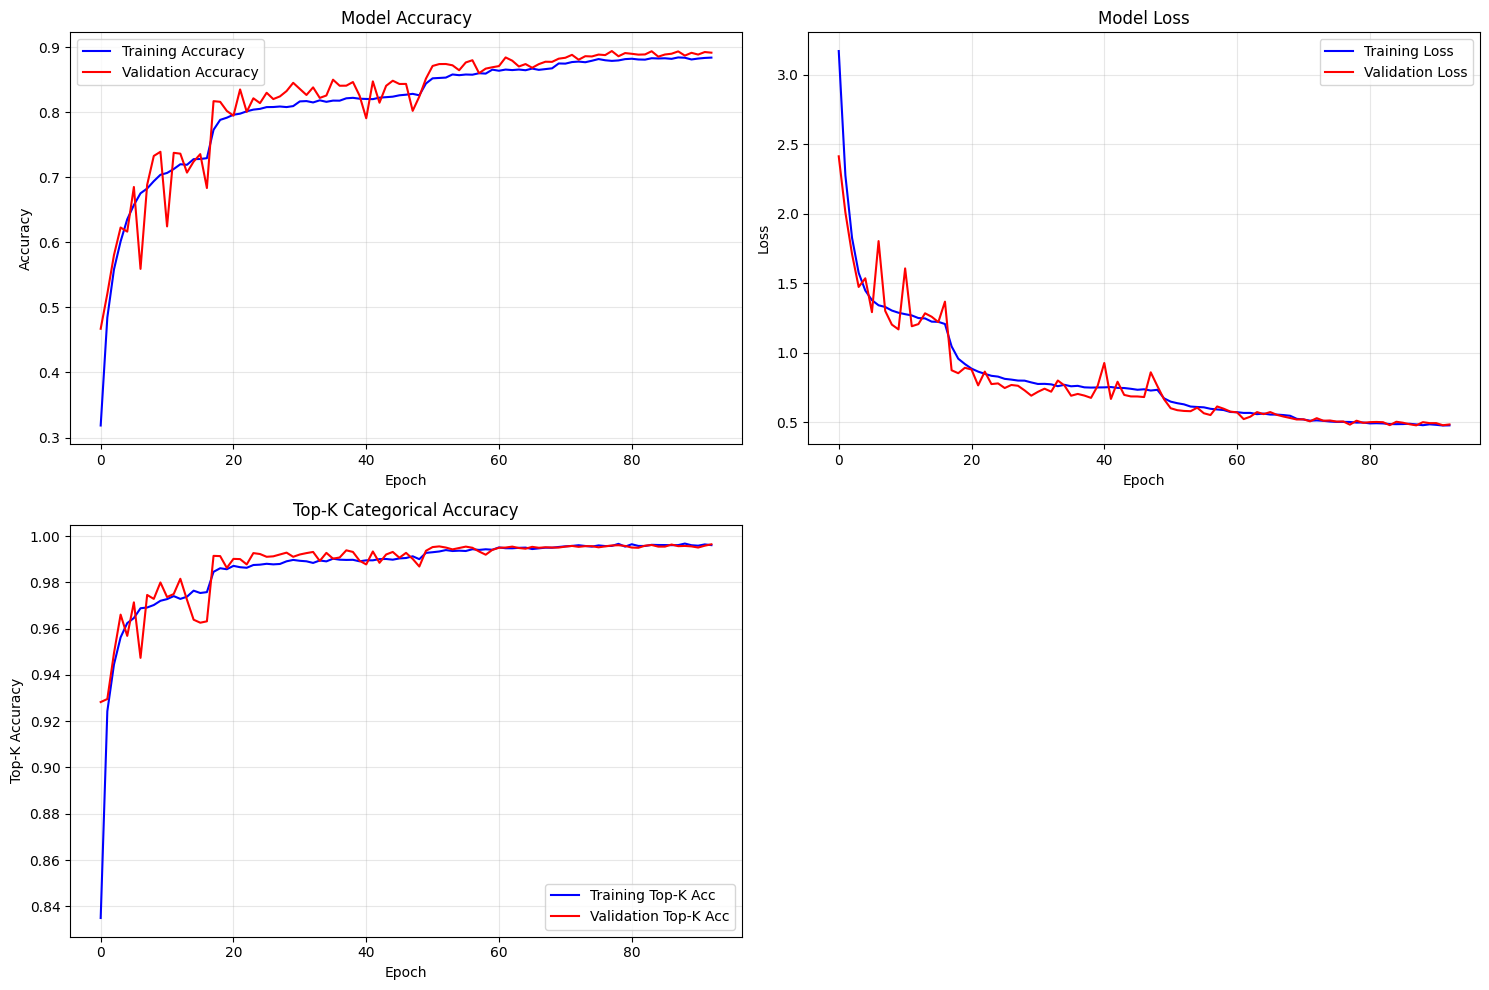

Final Training Accuracy: 0.8839 (88.39%)
Final Validation Accuracy: 0.8915 (89.15%)
Final Training Loss: 0.4786
Final Validation Loss: 0.4852
Overfitting Gap: -0.76%


In [97]:
# Training history analysis
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss', color='blue')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Top-K Accuracy
    if 'top_k_categorical_accuracy' in history.history:
        axes[1, 0].plot(history.history['top_k_categorical_accuracy'],
                       label='Training Top-K Acc', color='blue')
        axes[1, 0].plot(history.history['val_top_k_categorical_accuracy'],
                       label='Validation Top-K Acc', color='red')
        axes[1, 0].set_title('Top-K Categorical Accuracy')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Top-K Accuracy')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

    # Learning Rate (if available)
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'], color='green')
        axes[1, 1].set_title('Learning Rate Schedule')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Print final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print(f"Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")
    print(f"Overfitting Gap: {(final_train_acc - final_val_acc)*100:.2f}%")

plot_training_history(history)


In [98]:
# Load best model
print("Loading best model...")
best_model = tf.keras.models.load_model('best_model_32x32.h5')

# Evaluate on validation set
print("=== DETAILED EVALUATION ===")
val_loss, val_accuracy, val_top_k = best_model.evaluate(
    validation_generator,
    verbose=1
)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Validation Top-K Accuracy: {val_top_k:.4f} ({val_top_k*100:.2f}%)")


Loading best model...


=== DETAILED EVALUATION ===
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8992 - loss: 0.4686 - top_k_categorical_accuracy: 0.9958
Validation Loss: 0.4838
Validation Accuracy: 0.8940 (89.40%)
Validation Top-K Accuracy: 0.9960 (99.60%)


157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step
=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    airplane       0.93      0.87      0.90      1005
  automobile       0.94      0.96      0.95       974
        bird       0.88      0.86      0.87      1032
         cat       0.86      0.73      0.79      1016
        deer       0.88      0.92      0.90       999
         dog       0.86      0.79      0.83       937
        frog       0.84      0.96      0.89      1030
       horse       0.92      0.93      0.93      1001
        ship       0.92      0.96      0.94      1025
       truck       0.91      0.96      0.93       981

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



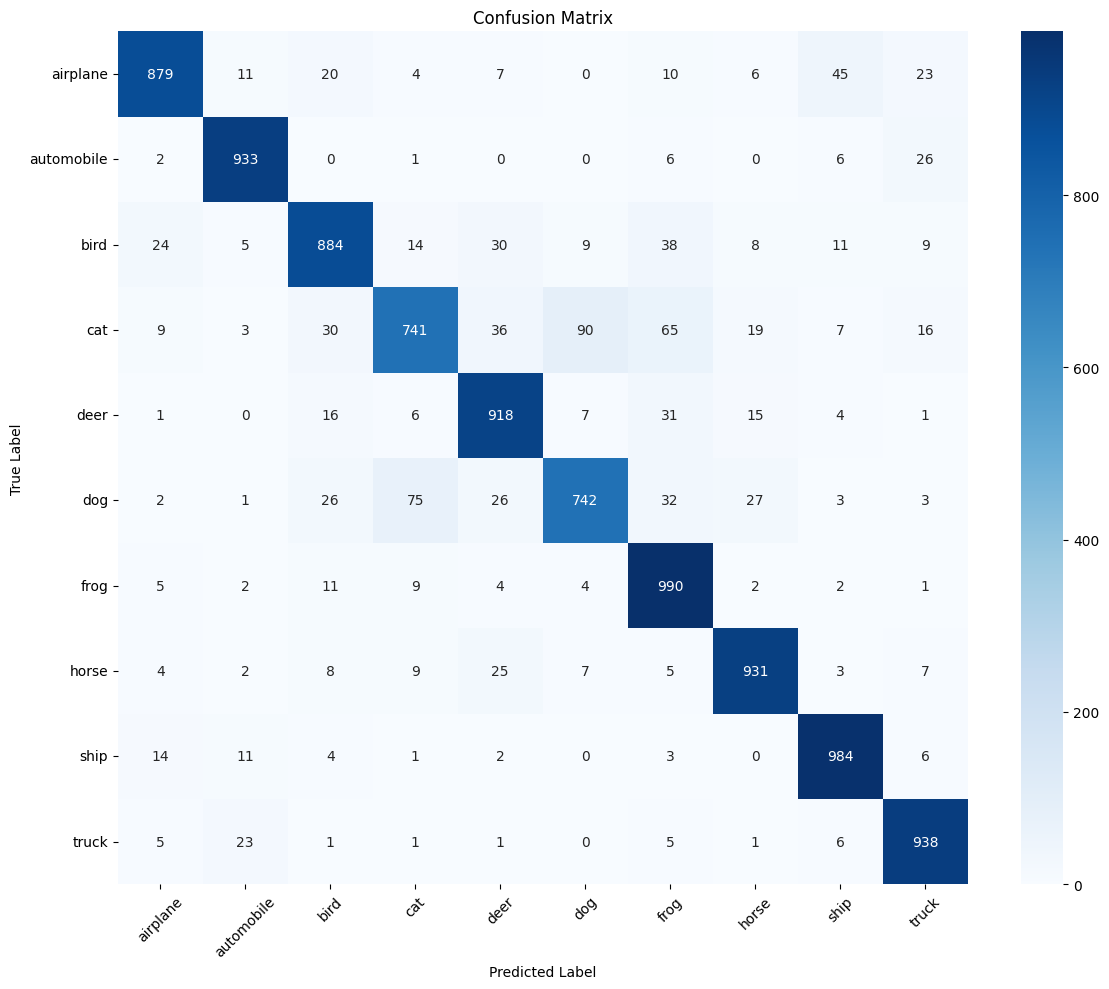


=== PER-CLASS ACCURACY ===
Class 'airplane': 0.8746 (87.46%)
Class 'automobile': 0.9579 (95.79%)
Class 'bird': 0.8566 (85.66%)
Class 'cat': 0.7293 (72.93%)
Class 'deer': 0.9189 (91.89%)
Class 'dog': 0.7919 (79.19%)
Class 'frog': 0.9612 (96.12%)
Class 'horse': 0.9301 (93.01%)
Class 'ship': 0.9600 (96.00%)
Class 'truck': 0.9562 (95.62%)


In [99]:
# Detailed per-class evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions on validation set
validation_generator.reset()
val_predictions = best_model.predict(validation_generator, verbose=1)
val_pred_classes = np.argmax(val_predictions, axis=1)

# Get true labels
val_true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
print("=== CLASSIFICATION REPORT ===")
print(classification_report(val_true_classes, val_pred_classes,
                          target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(val_true_classes, val_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\n=== PER-CLASS ACCURACY ===")
for i, (label, acc) in enumerate(zip(class_labels, class_accuracy)):
    print(f"Class '{label}': {acc:.4f} ({acc*100:.2f}%)")


Total misclassified samples: 1060
Misclassification rate: 10.60%


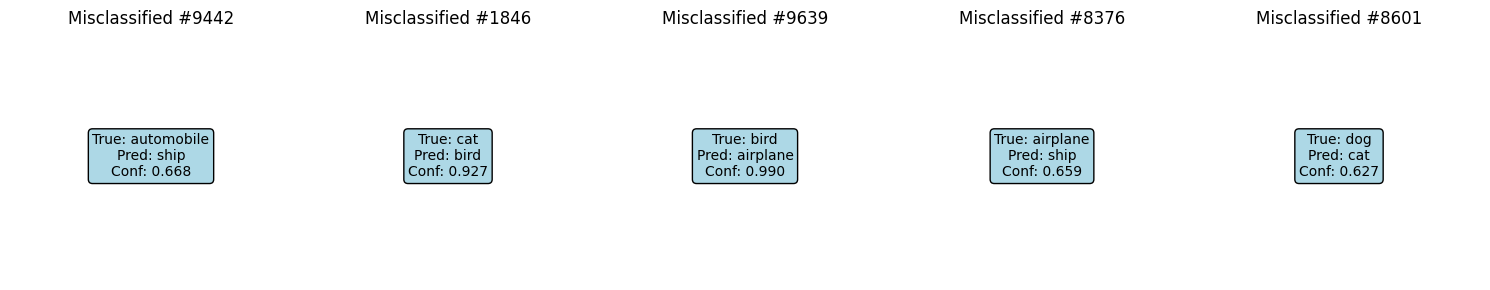

In [100]:
# Analyze misclassified samples
def analyze_misclassifications(val_generator, predictions, true_classes, n_samples=5):
    """Analyze and visualize misclassified samples"""
    pred_classes = np.argmax(predictions, axis=1)
    misclassified_indices = np.where(pred_classes != true_classes)[0]

    print(f"Total misclassified samples: {len(misclassified_indices)}")
    print(f"Misclassification rate: {len(misclassified_indices)/len(true_classes)*100:.2f}%")

    if len(misclassified_indices) == 0:
        print("No misclassifications found!")
        return

    # Sample some misclassified examples
    sample_indices = np.random.choice(misclassified_indices,
                                    min(n_samples, len(misclassified_indices)),
                                    replace=False)

    fig, axes = plt.subplots(1, len(sample_indices), figsize=(15, 3))
    if len(sample_indices) == 1:
        axes = [axes]

    class_names = list(val_generator.class_indices.keys())

    for i, idx in enumerate(sample_indices):
        # Get image (this is tricky with generator, simplified approach)
        true_class = class_names[true_classes[idx]]
        pred_class = class_names[pred_classes[idx]]
        confidence = predictions[idx].max()

        axes[i].text(0.5, 0.5, f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}',
                    ha='center', va='center', transform=axes[i].transAxes,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        axes[i].set_title(f'Misclassified #{idx}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

analyze_misclassifications(validation_generator, val_predictions, val_true_classes)


=== MAKING PREDICTIONS ON TEST SET ===
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
Test predictions shape: (10000, 10)
Average prediction confidence: 0.9160
Min confidence: 0.2238
Max confidence: 1.0000


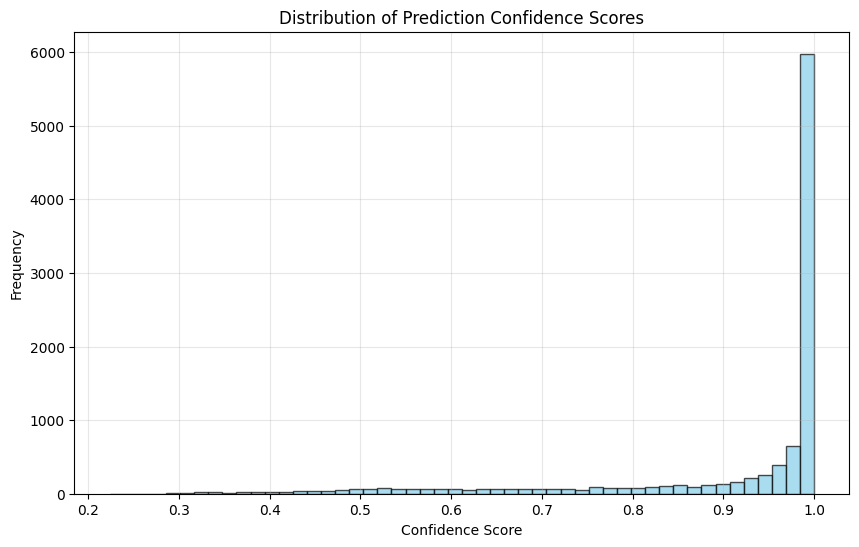

In [101]:
# Make predictions on test set
print("=== MAKING PREDICTIONS ON TEST SET ===")
test_generator.reset()
test_predictions = best_model.predict(test_generator, verbose=1)

# Get predicted classes
test_pred_classes = np.argmax(test_predictions, axis=1)

# Get prediction confidence scores
test_pred_confidence = np.max(test_predictions, axis=1)

print(f"Test predictions shape: {test_predictions.shape}")
print(f"Average prediction confidence: {test_pred_confidence.mean():.4f}")
print(f"Min confidence: {test_pred_confidence.min():.4f}")
print(f"Max confidence: {test_pred_confidence.max():.4f}")

# Distribution of confidence scores
plt.figure(figsize=(10, 6))
plt.hist(test_pred_confidence, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Prediction Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()


In [102]:
# Map predictions back to original labels
class_names = list(train_generator.class_indices.keys())
test_pred_labels = [class_names[i] for i in test_pred_classes]

# Create submission dataframe
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'label': test_pred_labels
})

# Display submission preview
print("=== SUBMISSION PREVIEW ===")
print(submission_df.head(10))
print(f"\nSubmission shape: {submission_df.shape}")

# Check label distribution in predictions
pred_distribution = pd.Series(test_pred_labels).value_counts().sort_index()
print("\n=== PREDICTION DISTRIBUTION ===")
for label, count in pred_distribution.items():
    print(f"Predicted '{label}': {count} samples ({count/len(test_pred_labels)*100:.1f}%)")

# Save submission
submission_df.to_csv('submission_32x32.csv', index=False)
print("\n✓ Submission saved to 'submission_32x32.csv'")


=== SUBMISSION PREVIEW ===
          id       label
0  50000.png         cat
1  50001.png        ship
2  50002.png        ship
3  50003.png        ship
4  50004.png        frog
5  50005.png        frog
6  50006.png  automobile
7  50007.png        frog
8  50008.png         cat
9  50009.png  automobile

Submission shape: (10000, 2)

=== PREDICTION DISTRIBUTION ===
Predicted 'airplane': 941 samples (9.4%)
Predicted 'automobile': 1038 samples (10.4%)
Predicted 'bird': 937 samples (9.4%)
Predicted 'cat': 829 samples (8.3%)
Predicted 'deer': 1072 samples (10.7%)
Predicted 'dog': 902 samples (9.0%)
Predicted 'frog': 1164 samples (11.6%)
Predicted 'horse': 1009 samples (10.1%)
Predicted 'ship': 1046 samples (10.5%)
Predicted 'truck': 1062 samples (10.6%)

✓ Submission saved to 'submission_32x32.csv'


In [112]:
# Test Time Augmentation (TTA) for better predictions
def test_time_augmentation(model, test_generator, n_augmentations=5):
    """Apply test time augmentation for more robust predictions"""
    print(f"Applying Test Time Augmentation with {n_augmentations} augmentations...")

    # Create augmented test generator
    tta_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True
    )

    all_predictions = []

    for aug_idx in range(n_augmentations):
        print(f"Augmentation {aug_idx + 1}/{n_augmentations}")

        # Create new generator for this augmentation
        aug_generator = tta_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory='/content/cifar_competition/test_images',
            x_col='id',
            y_col=None,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode=None,
            shuffle=False,
            seed=42 + aug_idx  # Different seed for each augmentation
        )

        # Get predictions
        predictions = model.predict(aug_generator, verbose=0)
        all_predictions.append(predictions)

    # Average all predictions
    avg_predictions = np.mean(all_predictions, axis=0)
    return avg_predictions

# Apply TTA (optional - comment out if not needed)
tta_predictions = test_time_augmentation(best_model, test_generator, n_augmentations=5)
test_pred_classes_tta = np.argmax(tta_predictions, axis=1)
test_pred_labels_tta = [class_names[i] for i in test_pred_classes_tta]

# # Create TTA submission
submission_tta_df = pd.DataFrame({
    'id': test_df['id'],
    'label': test_pred_labels_tta
})
submission_tta_df.to_csv('submission_32x32_tta.csv', index=False)
print("✓ TTA Submission saved to 'submission_32x32_tta.csv'")

Applying Test Time Augmentation with 5 augmentations...
Augmentation 1/5
Found 10000 validated image filenames.
Augmentation 2/5
Found 10000 validated image filenames.
Augmentation 3/5
Found 10000 validated image filenames.
Augmentation 4/5
Found 10000 validated image filenames.
Augmentation 5/5
Found 10000 validated image filenames.
✓ TTA Submission saved to 'submission_32x32_tta.csv'


In [ ]:
# Cross-Validation for more robust evaluation
def cross_validation_evaluation(train_df, n_folds=5):
    """Perform cross-validation to get more robust performance estimates"""
    print(f"=== {n_folds}-FOLD CROSS VALIDATION ===")

    from sklearn.model_selection import StratifiedKFold

    # Prepare data
    X = train_df['id'].values
    y = train_df['label'].values

    # Create stratified k-fold
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    cv_scores = []
    fold_histories = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n--- FOLD {fold + 1}/{n_folds} ---")

        # Create fold dataframes
        fold_train_df = train_df.iloc[train_idx].reset_index(drop=True)
        fold_val_df = train_df.iloc[val_idx].reset_index(drop=True)

        print(f"Train samples: {len(fold_train_df)}")
        print(f"Validation samples: {len(fold_val_df)}")

        # Create generators for this fold
        fold_train_gen = train_datagen.flow_from_dataframe(
            dataframe=fold_train_df,
            directory='/content/cifar_competition/train_images',
            x_col='id',
            y_col='label',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=True,
            seed=42
        )

        fold_val_gen = val_datagen.flow_from_dataframe(
            dataframe=fold_val_df,
            directory='/content/cifar_competition/train_images',
            x_col='id',
            y_col='label',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=False,
            seed=42
        )

        # Create and train model for this fold
        fold_model = create_optimized_cnn(num_classes)
        fold_model.compile(
            optimizer=AdamW(learning_rate=0.001, weight_decay=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Train with early stopping
        fold_callbacks = [
            EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-8)
        ]

        fold_history = fold_model.fit(
            fold_train_gen,
            epochs=50,  # Reduced for CV
            validation_data=fold_val_gen,
            callbacks=fold_callbacks,
            verbose=0
        )

        # Evaluate fold
        fold_score = fold_model.evaluate(fold_val_gen, verbose=0)[1]  # accuracy
        cv_scores.append(fold_score)
        fold_histories.append(fold_history)

        print(f"Fold {fold + 1} Accuracy: {fold_score:.4f} ({fold_score*100:.2f}%)")

    # Calculate CV statistics
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)

    print(f"\n=== CROSS VALIDATION RESULTS ===")
    print(f"Individual fold scores: {[f'{score:.4f}' for score in cv_scores]}")
    print(f"Mean CV Accuracy: {mean_score:.4f} ± {std_score:.4f}")
    print(f"95% Confidence Interval: [{mean_score - 1.96*std_score:.4f}, {mean_score + 1.96*std_score:.4f}]")

    return cv_scores, fold_histories

# Uncomment to run cross-validation (time-consuming)
cv_scores, fold_histories = cross_validation_evaluation(train_df, n_folds=5)


=== 5-FOLD CROSS VALIDATION ===

--- FOLD 1/5 ---
Train samples: 40000
Validation samples: 10000
Found 40000 validated image filenames belonging to 10 classes.
Found 10000 validated image filenames belonging to 10 classes.
Fold 1 Accuracy: 0.8683 (86.83%)

--- FOLD 2/5 ---
Train samples: 40000
Validation samples: 10000
Found 40000 validated image filenames belonging to 10 classes.
Found 10000 validated image filenames belonging to 10 classes.


In [ ]:
# Model Ensemble (Multiple Models)
def create_ensemble_models(num_classes):
    """Create multiple models for ensemble"""
    models = []

    # Model 1: Original CNN
    model1 = create_optimized_cnn(num_classes)
    model1.compile(
        optimizer=AdamW(learning_rate=0.001, weight_decay=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    models.append(('CNN_Original', model1))

    # Model 2: ResNet Small
    model2 = create_resnet_small(num_classes)
    model2.compile(
        optimizer=AdamW(learning_rate=0.001, weight_decay=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    models.append(('ResNet_Small', model2))

    # Model 3: CNN with different architecture
    model3 = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.25),

        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model3.compile(
        optimizer=AdamW(learning_rate=0.0008, weight_decay=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    models.append(('CNN_Alternative', model3))

    return models

def train_ensemble(models, train_gen, val_gen, epochs=50):
    """Train ensemble of models"""
    trained_models = []

    for name, model in models:
        print(f"\n=== TRAINING {name} ===")

        callbacks = [
            EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-8)
        ]

        history = model.fit(
            train_gen,
            epochs=epochs,
            validation_data=val_gen,
            callbacks=callbacks,
            verbose=1
        )

        # Evaluate model
        val_loss, val_acc = model.evaluate(val_gen, verbose=0)
        print(f"{name} Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")

        trained_models.append((name, model, history))

    return trained_models

def ensemble_predict(trained_models, test_generator):
    """Make ensemble predictions"""
    all_predictions = []

    for name, model, _ in trained_models:
        print(f"Getting predictions from {name}...")
        test_generator.reset()
        predictions = model.predict(test_generator, verbose=0)
        all_predictions.append(predictions)

    # Average predictions
    ensemble_predictions = np.mean(all_predictions, axis=0)
    return ensemble_predictions

# Uncomment to use ensemble (resource-intensive)

ensemble_models = create_ensemble_models(num_classes)  # Pastikan `num_classes` sudah didefinisikan
trained_ensemble = train_ensemble(ensemble_models, train_generator, validation_generator)
ensemble_preds = ensemble_predict(trained_ensemble, test_generator)
ensemble_classes = np.argmax(ensemble_preds, axis=1)
ensemble_labels = [class_names[i] for i in ensemble_classes]  # Pastikan `class_names` sudah didefinisikan

# # Save ensemble submission
ensemble_submission = pd.DataFrame({
    'id': test_df['id'],
    'label': ensemble_labels
})
ensemble_submission.to_csv('submission_ensemble.csv', index=False)
print("✓ Ensemble submission saved")